# Graph Neural Network for Multi-Asset Market Modeling 📈

This notebook demonstrates a sophisticated GNN approach for financial time series prediction, featuring:

- Synthetic data for 3 assets (A,B,C)
- **Online-learned correlation window:** The optimal rolling correlation window size is treated as a trainable parameter.
- **Vectorized GNN Layer** using matrix multiplication for efficiency (3 nodes).
- **LSTM** temporal encoder, processing sequences of GNN embeddings.
- **Prediction:** Next-step direction (Up/Down) of Asset A.
- **Robustness:** NaN-safe normalization and explicit NaN detection during training.

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

## 1) Generate Synthetic Market Data 🎲

In [2]:
T = 5000
time = np.arange(T)

def make_price_series(mu=0.0002, sigma=0.003):
    # Simple geometric Brownian motion-like series
    returns = np.random.normal(mu, sigma, T)
    return 100 + np.cumsum(returns)

price_A = make_price_series()
price_B = make_price_series(mu=0.0001)
price_C = make_price_series(mu=-0.0001)

vol_A = np.random.randint(50, 500, T)
vol_B = np.random.randint(80, 600, T)
vol_C = np.random.randint(100, 700, T)

df = pd.DataFrame({
    "time": time,
    "price_A": price_A,
    "price_B": price_B,
    "price_C": price_C,
    "vol_A": vol_A,
    "vol_B": vol_B,
    "vol_C": vol_C
})

# Target: Next-step direction (1 if price increases, 0 otherwise)
df["dir_A_next"] = (df.price_A.shift(-1) > df.price_A).astype(int)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,time,price_A,price_B,price_C,vol_A,vol_B,vol_C,dir_A_next
0,0,100.001690,99.998829,99.997865,482,548,315,0
1,1,100.001475,99.997568,99.996848,249,172,513,1
2,2,100.003618,99.992282,99.994956,291,571,309,1
3,3,100.008388,99.991391,99.995187,288,181,157,0
4,4,100.007885,99.993690,99.998679,352,572,142,0


## 2) Correlation Window Learner 💡

This module parameterizes the correlation window size using $W = e^{\log(W)}$, ensuring the window is always positive and differentiable. The optimal window $W$ is learned via backpropagation.

In [3]:
class CorrWindowLearner(nn.Module):
    def __init__(self, initial_win=20):
        super().__init__()
        # Initialize log_win parameter based on the initial guess
        self.log_win = nn.Parameter(torch.log(torch.tensor(float(initial_win))))

    def forward(self):
        # The window size is W = exp(log_W)
        return torch.exp(self.log_win)  # ensure > 0

## 3) Dataset with Dynamic Correlation 📊

The dataset provides the time sequence of normalized features ($x_{\text{seq}}$) and the target. The adjacency matrix (correlation) is **not** precomputed but calculated dynamically using the learned window $W$ during the model's forward pass, allowing $W$ to be a part of the computation graph.

In [4]:
class MarketDataset(Dataset):
    def __init__(self, df, window=12, normalize=True):
        self.df = df.reset_index(drop=True)
        self.window = window
        self.N = len(df)
        self.normalize = normalize

        if normalize:
            prices = df[["price_A","price_B","price_C"]].values
            self.price_mean = prices.mean(axis=0)
            self.price_std = prices.std(axis=0) + 1e-6

            lv = np.log1p(df[["vol_A","vol_B","vol_C"]].values)
            self.vol_mean = lv.mean(axis=0)
            self.vol_std = lv.std(axis=0) + 1e-6

    def __len__(self):
        return self.N - self.window - 1

    def _compute_corr(self, t, win):
        w = int(max(3, win))
        s = max(0, t - w)
        sub = self.df.iloc[s:t]

        pa = sub.price_A.pct_change().dropna()
        pb = sub.price_B.pct_change().dropna()
        pc = sub.price_C.pct_change().dropna()

        def corr(a, b):
            if len(a) < 3:
                return 0.0
            return float(np.corrcoef(a, b)[0,1])

        cAB = corr(pa, pb)
        cAC = corr(pa, pc)
        cBC = corr(pb, pc)

        adj = np.array([
            [0, cAB, cAC],
            [cAB, 0, cBC],
            [cAC, cBC, 0]
        ], dtype=np.float32)

        return adj

    def __getitem__(self, idx):
        x_seq = []
        global_start_idx = idx

        for t in range(idx, idx + self.window):
            row = self.df.iloc[t]

            price = np.array([row.price_A,row.price_B,row.price_C],dtype=np.float32)
            vol = np.log1p(np.array([row.vol_A,row.vol_B,row.vol_C],dtype=np.float32))

            price = (price - self.price_mean)/self.price_std
            vol   = (vol   - self.vol_mean)/self.vol_std

            nf = np.stack([price,vol],axis=1).astype(np.float32)
            x_seq.append(torch.tensor(nf))

        target = int(self.df.iloc[idx+self.window].dir_A_next)
        return x_seq, global_start_idx, target

def collate_fn(batch):
    """
    batch = [(x_seq, global_start_idx, target)]
    """
    x_seq, global_start_idx, target = batch[0]
    return x_seq, torch.tensor([global_start_idx]), torch.tensor([target], dtype=torch.long)


## 4) Vectorized GNN Layer 🌐

This layer uses simple matrix multiplication for message passing, $M = \mathbf{A} \mathbf{X} \mathbf{W}_{\text{msg}}$, where $\mathbf{A}$ is the correlation-based adjacency matrix and $\mathbf{X}$ are the node features. 

In [5]:
class SimpleGNN(nn.Module):
    def __init__(self, in_dim=2, hidden=16):
        super().__init__()
        self.lin_msg = nn.Linear(in_dim, hidden)
        self.lin_upd = nn.Linear(in_dim + hidden, hidden)

    def forward(self, x, adj):
        # x: (3, in_dim), adj: (3, 3)
        
        # Message Passing: msg = ADJ * X * W_msg
        msg = torch.matmul(adj, self.lin_msg(x))  # (3, hidden)
        
        # Update Step: Concatenate node's own features with aggregated message
        h = torch.cat([x, msg], dim=-1) # (3, in_dim + hidden)
        
        out = torch.tanh(self.lin_upd(h))  # (3, hidden)
        
        if torch.isnan(out).any():
            # Explicit check for training stability
            raise RuntimeError("NaN detected in GNN forward")
            
        return out

## 5) Full Model: GNN + LSTM + Classifier 🧠

In [6]:
class GNN_LSTM_Model(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        self.hidden = hidden
        self.gnn = SimpleGNN(2, hidden)
        # LSTM input size is hidden * 3 (flattened embeddings of all 3 nodes)
        self.lstm = nn.LSTM(hidden * 3, 64, batch_first=True)
        self.fc = nn.Linear(64, 2)
        self.corr_win = CorrWindowLearner(initial_win=20)

    def forward(self, x_seq, ds, global_start_idx):
        # Get the learned correlation window W (tensor)
        win_tensor = self.corr_win()
        win = win_tensor.item() # Get Python float value
        
        gnn_embs = []
        window_size = len(x_seq)
        
        # global_start_idx is the index in the original dataframe/dataset of the first element (t=0) in x_seq
        for i, x in enumerate(x_seq):
            # t is the global index in the original dataset for the current timestep x
            t = global_start_idx + i 
            
            # 1. Compute ADJ matrix based on the learned window W
            adj_np = ds._compute_corr(t, win) 
            adj = torch.tensor(adj_np, dtype=torch.float32, device=x.device)
            
            # 2. Run GNN on node features and ADJ
            h = self.gnn(x, adj)
            
            # 3. Flatten the GNN output for all 3 nodes to feed into LSTM
            gnn_embs.append(h.flatten())  # shape (hidden * 3)

        # Stack GNN embeddings into sequence and add batch dim: (1, seq_len, feat_dim)
        gnn_embs = torch.stack(gnn_embs).unsqueeze(0)
        
        # 4. Run LSTM
        out, _ = self.lstm(gnn_embs)
        
        # 5. Classifier on the last hidden state of the LSTM sequence
        logits = self.fc(out[:, -1, :])
        return logits

## 6) Train/Validation Setup 🚀

In [7]:
WINDOW_SIZE = 12

train_df = df.iloc[:4000].copy().reset_index(drop=True)
val_df   = df.iloc[4000:].copy().reset_index(drop=True)

train_ds = MarketDataset(train_df, window=WINDOW_SIZE)
val_ds   = MarketDataset(val_df, window=WINDOW_SIZE)

train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")


Train samples: 3987, Val samples: 987


## 7) Training Loop with NaN Check 🛡️

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN_LSTM_Model(hidden=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print(f"Using device: {device}")

def train_epoch():
    model.train()
    total, correct = 0, 0
    loss_sum = 0

    for i, batch in enumerate(train_loader):
        x_seq_list, global_start_idx, y = batch

        x_seq = [x.to(device) for x in x_seq_list]
        y = y.to(device).squeeze()      # shape → (1,) → scalar
        global_start = global_start_idx.to(device).item()

        optimizer.zero_grad()

        logits = model(x_seq, train_ds, global_start)

        loss = criterion(logits, y.unsqueeze(0))
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += 1

    return loss_sum / total, correct / total


def eval_epoch(loader, ds):
    model.eval()
    total, correct = 0, 0
    loss_sum = 0

    with torch.no_grad():
        for batch in loader:
            x_seq_list, global_start_idx, y = batch

            x_seq = [x.to(device) for x in x_seq_list]
            y = y.to(device).squeeze()
            global_start = global_start_idx.item()

            logits = model(x_seq, ds, global_start)

            loss = criterion(logits, y.unsqueeze(0))
            loss_sum += loss.item()

            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += 1

    return loss_sum / total, correct / total


# Run Training
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(10):
    tr_loss, tr_acc = train_epoch()
    va_loss, va_acc = eval_epoch(val_loader, val_ds)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    print(
        f"Epoch {epoch+1:02d}: "
        f"train_loss={tr_loss:.4f}, val_loss={va_loss:.4f}, "
        f"train_acc={tr_acc:.3f}, val_acc={va_acc:.3f}, "
        f"win={model.corr_win().item():.2f}"
    )


Using device: cpu
Epoch 01: train_loss=0.6921, val_loss=0.6920, train_acc=0.530, val_acc=0.525, win=20.00
Epoch 02: train_loss=0.6912, val_loss=0.6919, train_acc=0.534, val_acc=0.525, win=20.00
Epoch 03: train_loss=0.6909, val_loss=0.6920, train_acc=0.535, val_acc=0.523, win=20.00
Epoch 04: train_loss=0.6905, val_loss=0.6926, train_acc=0.536, val_acc=0.521, win=20.00
Epoch 05: train_loss=0.6893, val_loss=0.6943, train_acc=0.540, val_acc=0.528, win=20.00
Epoch 06: train_loss=0.6873, val_loss=0.7003, train_acc=0.550, val_acc=0.512, win=20.00
Epoch 07: train_loss=0.6833, val_loss=0.7030, train_acc=0.561, val_acc=0.518, win=20.00
Epoch 08: train_loss=0.6779, val_loss=0.7074, train_acc=0.580, val_acc=0.515, win=20.00
Epoch 09: train_loss=0.6693, val_loss=0.7129, train_acc=0.582, val_acc=0.515, win=20.00
Epoch 10: train_loss=0.6525, val_loss=0.7211, train_acc=0.606, val_acc=0.509, win=20.00


## 8) Results and Analysis 🔬


--- Learned Window Analysis ---
Final Learned Correlation Window W: 20.00 steps


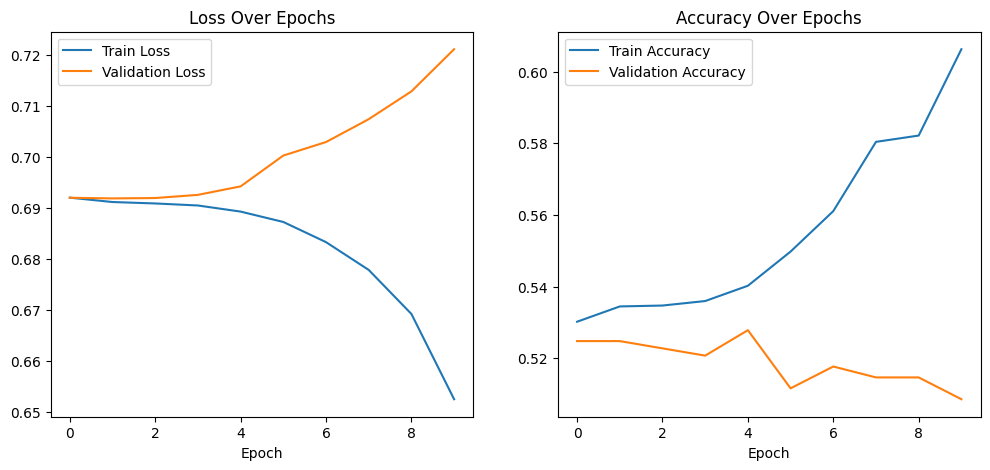

In [9]:
print("\n--- Learned Window Analysis ---")
print("Final Learned Correlation Window W:", f"{model.corr_win().item():.2f} steps")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label='Train Loss'); 
plt.plot(val_losses,label='Validation Loss')
plt.legend(); 
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(train_accs,label='Train Accuracy'); 
plt.plot(val_accs,label='Validation Accuracy')
plt.legend(); 
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.show()